# Facies classification utilizing an Adaptive Boosted Random Forest


[Ryan Thielke](http://www.linkedin.com/in/ryan-thielke-b987012a)


In the following, we provide a possible solution to the facies classification problem described in https://github.com/seg/2016-ml-contest.


## Exploring the data

In [1]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import sys
sys.path.append("..")

#Import standard pydata libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
filename = '../facies_vectors.csv'
training_data = pd.read_csv(filename)
#training_data['Well Name'] = training_data['Well Name'].astype('category')
#training_data['Formation'] = training_data['Formation'].astype('category')
training_data['train'] = 1
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,train
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000,4149.0
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852,1.0
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644,0.0
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000,1.0
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,NaN,1.000000,0.277000,1.0
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,NaN,2.000000,0.528000,1.0
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,NaN,2.000000,0.769000,1.0
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000,1.0


In [3]:
validation_data = pd.read_csv("../validation_data_nofacies.csv")
#validation_data['Well Name'] = validation_data['Well Name'].astype('category')
#validation_data['Formation'] = validation_data['Formation'].astype('category')
validation_data['train'] = 0
validation_data.describe()

,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,train
count,830.000000,830.00000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.0
mean,2987.070482,57.61173,0.666312,2.851964,11.655277,3.654178,1.678313,0.535807,0.0
std,94.391925,27.52774,0.288367,3.442074,5.190236,0.649793,0.467405,0.283062,0.0
min,2808.000000,12.03600,-0.468000,-8.900000,1.855000,2.113000,1.000000,0.013000,0.0
25%,2911.625000,36.77325,0.541000,0.411250,7.700000,3.171500,1.000000,0.300000,0.0
50%,2993.750000,58.34450,0.675000,2.397500,10.950000,3.515500,2.000000,0.547500,0.0
75%,3055.375000,73.05150,0.850750,4.600000,14.793750,4.191500,2.000000,0.778000,0.0
max,3160.500000,220.41300,1.507000,16.500000,31.335000,6.321000,2.000000,1.000000,0.0


In [4]:
all_data = training_data.append(validation_data)
all_data.describe()

,DeltaPHI,Depth,Facies,GR,ILD_log10,NM_M,PE,PHIND,RELPOS,train
count,4979.000000,4979.000000,4149.000000,4979.000000,4979.000000,4979.000000,4062.000000,4979.000000,4979.000000,4979.000000
mean,4.144012,2920.237297,4.503254,63.713364,0.660690,1.545089,3.710540,12.943383,0.524178,0.833300
std,5.049037,131.086857,2.474324,29.979746,0.258971,0.498013,0.852033,6.871145,0.286069,0.372745
min,-21.832000,2573.500000,1.000000,10.149000,-0.468000,1.000000,0.200000,0.550000,0.000000,0.000000
25%,1.330000,2837.750000,NaN,43.197000,0.503623,1.000000,NaN,8.350000,0.281000,1.000000
50%,3.900000,2943.000000,NaN,64.085000,0.645226,2.000000,NaN,11.800000,0.530000,1.000000
75%,7.000000,3016.000000,NaN,78.555000,0.829000,2.000000,NaN,15.826000,0.771500,1.000000
max,19.312000,3160.500000,9.000000,361.150000,1.800000,2.000000,8.094000,84.400000,1.000000,1.000000


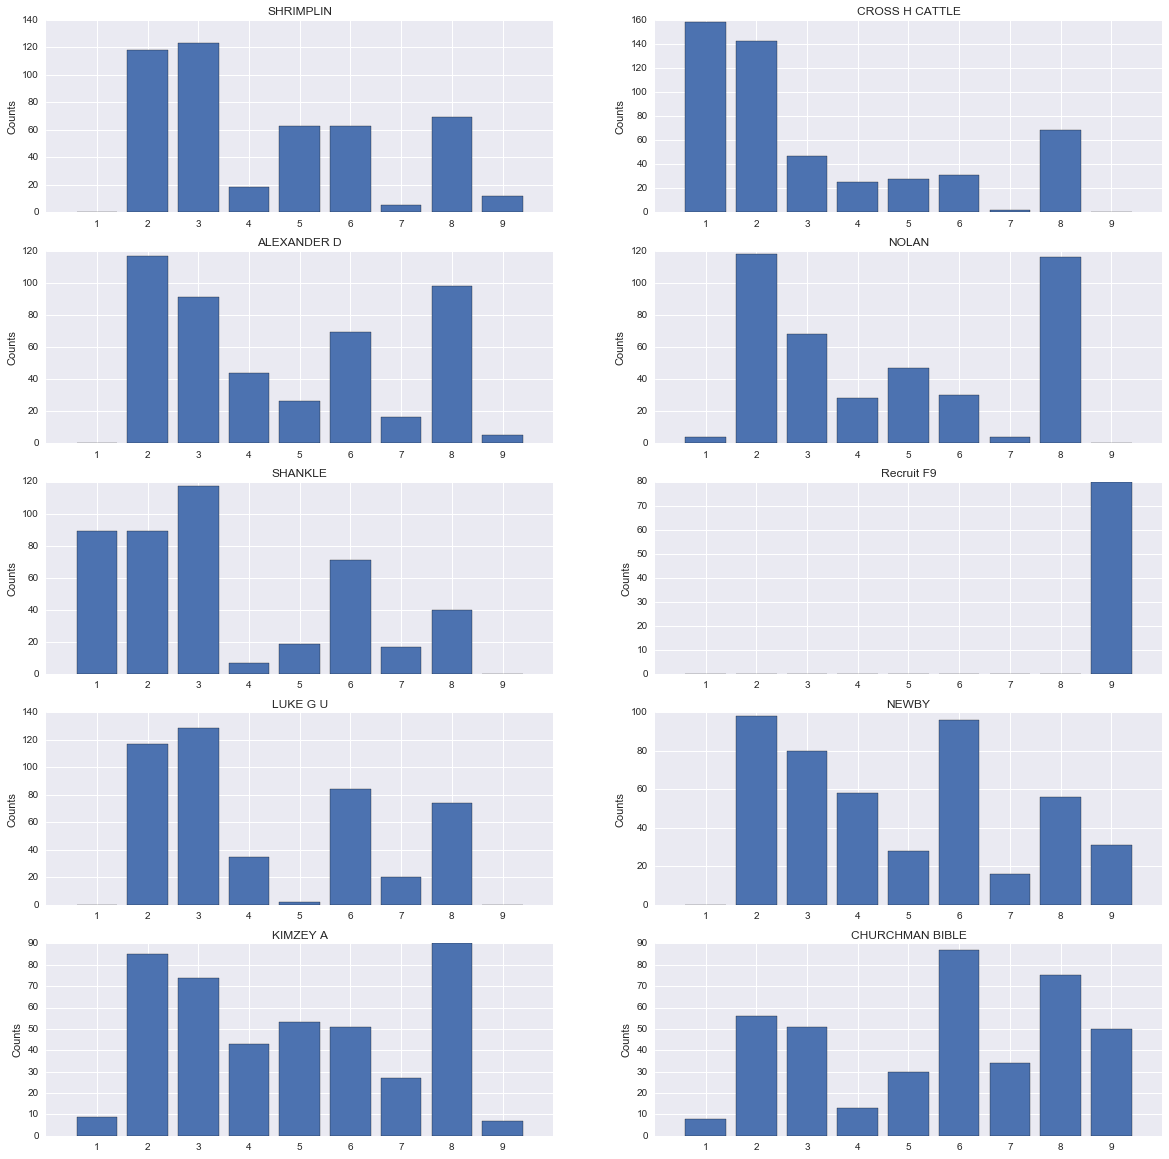

In [5]:
#Visualize the distribution of facies for each well
wells = training_data['Well Name'].unique()

fig, ax = plt.subplots(5,2, figsize=(20,20))
for i, well in enumerate(wells):
    row = i % ax.shape[0]
    column = i // ax.shape[0]
    counts = training_data[training_data['Well Name']==well].Facies.value_counts()
    data_for_well = [counts[j] if j in counts.index else 0 for j in range(1,10)]
    ax[row, column].bar(range(1,10), data_for_well, align='center')
    ax[row, column].set_title("{well}".format(well=well))
    ax[row, column].set_ylabel("Counts")
    ax[row, column].set_xticks(range(1,10))

plt.show()
    

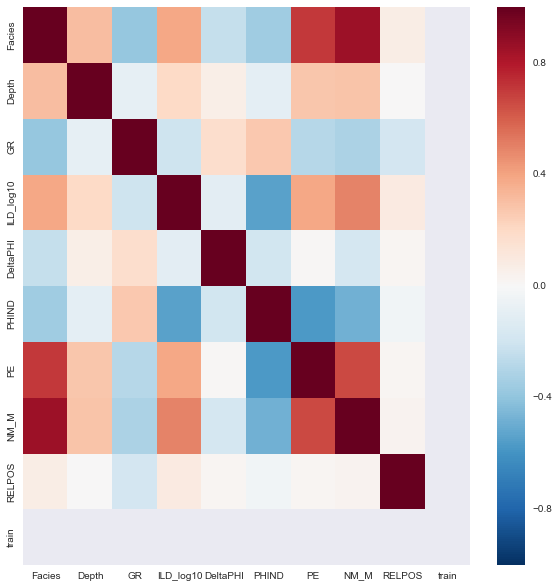

In [6]:
plt.figure(figsize=(10,10))
sns.heatmap(training_data.drop(['Formation', 'Well Name'], axis=1).corr())

# Feature Engineering

Here we will do a couple things to clean the data and attempt to create new features for our model to consume.

First, we will smooth the PE and GR features.
Second, we replace missing PE values with the mean of the entire dataset (might want to investigate other methods)
Last, we will encode the formations into integer values

In [7]:

dfs = []
for well in all_data['Well Name'].unique():
    df = all_data[all_data['Well Name']==well].copy(deep=True)
    df.sort_values('Depth', inplace=True)
    for col in ['PE']:
        smooth_col = 'smooth_'+col
        df[smooth_col] = pd.rolling_mean(df[col], window=25)
        df[smooth_col].fillna(method='ffill', inplace=True)
        df[smooth_col].fillna(method='bfill', inplace=True)
    dfs.append(df)
all_data = pd.concat(dfs)

all_data['PE'] = all_data.PE.fillna(all_data.PE.mean())
all_data['smooth_PE'] = all_data.smooth_PE.fillna(all_data.smooth_PE.mean())
formation_encoder = dict(zip(all_data.Formation.unique(), range(len(all_data.Formation.unique()))))
all_data['enc_formation'] = all_data.Formation.map(formation_encoder)

In [8]:
all_data.columns

Index(['DeltaPHI', 'Depth', 'Facies', 'Formation', 'GR', 'ILD_log10', 'NM_M',
       'PE', 'PHIND', 'RELPOS', 'Well Name', 'train', 'smooth_PE',
       'enc_formation'],
      dtype='object')

In [9]:
from sklearn import preprocessing

feature_names = all_data.drop(['Well Name', 'train', 'Depth', 'Formation', 'enc_formation', 'Facies'], axis=1).columns
train_labels = all_data.train.tolist()
facies_labels = all_data.Facies.tolist()
well_names = all_data['Well Name'].tolist()
depths = all_data.Depth.tolist()

scaler = preprocessing.StandardScaler().fit(all_data.drop(['Well Name', 'train', 'Depth', 'Formation', 'enc_formation', 'Facies'], axis=1))
scaled_features = scaler.transform(all_data.drop(['Well Name', 'train', 'Depth', 'Formation', 'enc_formation', 'Facies'], axis=1))

scaled_df = pd.DataFrame(scaled_features, columns=feature_names)
scaled_df['train'] = train_labels
scaled_df['Facies'] = facies_labels
scaled_df['Well Name'] = well_names
scaled_df['Depth'] = depths

In [10]:
def to_binary_vec(value, vec_length):
    vec = np.zeros(vec_length+1)
    vec[value] = 1
    return vec

catagorical_vars = []

for i in all_data.enc_formation:
    vec = to_binary_vec(i, all_data.enc_formation.max())
    catagorical_vars.append(vec)
    
catagorical_vars = np.array(catagorical_vars)

for i in range(catagorical_vars.shape[1]):
    scaled_df['f'+str(i)] = catagorical_vars[:,i]



In [11]:
'''
dfs = list()
for well in all_data['Well Name'].unique():
    tmp_df = all_data[all_data['Well Name'] == well].copy(deep=True)
    tmp_df.sort_values('Depth', inplace=True)
    for feature in ['PE', 'GR']:
        tmp_df['3'+feature] = tmp_df[feature] / tmp_df[feature].shift(1)
        
        tmp_df['3'+feature].fillna(0, inplace=True)
        
    dfs.append(tmp_df)
scaled_df = pd.concat(dfs)
'''

"\ndfs = list()\nfor well in all_data['Well Name'].unique():\n    tmp_df = all_data[all_data['Well Name'] == well].copy(deep=True)\n    tmp_df.sort_values('Depth', inplace=True)\n    for feature in ['PE', 'GR']:\n        tmp_df['3'+feature] = tmp_df[feature] / tmp_df[feature].shift(1)\n        \n        tmp_df['3'+feature].fillna(0, inplace=True)\n        \n    dfs.append(tmp_df)\nscaled_df = pd.concat(dfs)\n"

In [12]:
#Let's build a model
from sklearn import preprocessing
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics, cross_validation 
from classification_utilities import display_cm
import xgboost as xgb

In [14]:
scaled_df

,DeltaPHI,GR,ILD_log10,NM_M,PE,PHIND,RELPOS,smooth_PE,train,Facies,...,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13
0,1.140131,0.458243,0.012781,-1.094639,1.155912,-0.149682,1.663478,-0.593070,1,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.991865,0.485264,0.001196,-1.094639,0.506129,-0.055074,1.590062,-0.593070,1,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.110711,0.511618,-0.010390,-1.094639,-0.143654,0.015518,1.513150,-0.593070,1,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.932441,0.746800,-0.021975,-1.094639,-0.273610,0.024979,1.439734,-0.593070,1,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.853210,0.362502,-0.052870,-1.094639,-0.403567,0.051906,1.366317,-0.593070,1,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.952249,0.342153,-0.095350,-1.094639,-0.143654,0.064278,1.292901,-0.593070,1,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2.269173,0.333813,-0.118521,-1.094639,-0.013697,0.143603,1.215989,-0.593070,1,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2.447443,0.398197,-0.137830,-1.094639,-0.273610,0.142147,1.069157,-0.593070,1,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2.388019,0.336149,-0.141692,-1.094639,-0.403567,0.150880,0.995741,-0.593070,1,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2.526674,0.439562,-0.176448,-1.094639,-0.273610,0.185813,0.918828,-0.593070,1,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import xgboost as xgb
#We will take a look at an F1 score for each well
estimators=200
learning_rate=.01
random_state=0
facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']

title_length = 20 

training_data = scaled_df[scaled_df.train==1]
scores = list()

wells = training_data['Well Name'].unique()
for well in wells:
    blind = training_data[training_data['Well Name']==well]
    train = training_data[(training_data['Well Name']!=well)]
    
    train_X = train.drop(['Well Name', 'Facies', 'Depth', 'train'], axis=1)
    train_Y = train.Facies.values
    test_X = blind.drop(['Well Name', 'Facies', 'Depth', 'train'], axis=1)
    test_Y = blind.Facies.values
    
    gcf = xgb.XGBClassifier(n_estimators=2000, learning_rate=0.01)
    gcf.fit(train_X,train_Y)
    pred_Y = gcf.predict(test_X)
    f1 = metrics.f1_score(test_Y, pred_Y, average='micro')
    scores.append(f1)
    print("*"*title_length)
    print("{well}={f1:.4f}".format(well=well,f1=f1))
    print("*"*title_length)
print("Avg F1: {score}".format(score=sum(scores)/len(scores)))

********************
SHRIMPLIN=0.5987
********************


In [28]:
train_X, test_X, train_Y, test_Y = cross_validation.train_test_split(training_data.drop(['Well Name', 'Facies', 'Depth', 'train'], axis=1), training_data.Facies.values, test_size=.2)

In [29]:
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(3319, 22)
(3319,)
(830, 22)
(830,)


In [30]:
gcf = xgb.XGBClassifier(n_estimators=2000, learning_rate=0.05)
gcf.fit(train_X,train_Y)
pred_Y = gcf.predict(test_X)
cm = metrics.confusion_matrix(y_true=test_Y, y_pred=pred_Y)
display_cm(cm, facies_labels, display_metrics=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    45     8     2     0     0     0     0     0     0    55
     CSiS     4   153    21     0     1     1     0     1     0   181
     FSiS     3    25   120     1     0     0     0     0     0   149
     SiSh     0     1     0    52     1     8     1     4     0    67
       MS     0     1     0     1    32    12     1    10     0    57
       WS     0     0     1     6     9    85     1    19     0   121
        D     0     0     1     1     0     0    19     2     0    23
       PS     0     1     1     1     6    15     3   106     0   133
       BS     0     0     0     1     1     4     1     3    34    44

Precision  0.87  0.81  0.82  0.83  0.64  0.68  0.73  0.73  1.00  0.78
   Recall  0.82  0.85  0.81  0.78  0.56  0.70  0.83  0.80  0.77  0.78
       F1  0.84  0.83  0.81  0.80  0.60  0.69  0.78  0.76  0.87  0.78


In [31]:
validation_data = scaled_df[scaled_df.train==0]

In [32]:
validation_data.describe()

,DeltaPHI,GR,ILD_log10,NM_M,PE,PHIND,RELPOS,smooth_PE,train,Facies,...,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13
count,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.0,0.0,...,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,-0.255926,-0.203546,0.021710,0.267538,-0.073246,-0.187485,0.040656,-0.097669,0.0,NaN,...,0.040964,0.069880,0.050602,0.030120,0.046988,0.036145,0.020482,0.119277,0.068675,0.121687
std,0.681797,0.918303,1.113623,0.938635,0.844449,0.755443,0.989586,0.680501,0.0,NaN,...,0.198326,0.255098,0.219317,0.171022,0.211741,0.186762,0.141727,0.324310,0.253053,0.327121
min,-2.583725,-1.723916,-4.358801,-1.094639,-2.076108,-1.613923,-1.787083,-1.658141,0.0,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.739376,-0.898701,-0.462223,-1.094639,-0.700518,-0.763178,-0.783728,-0.558528,0.0,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-0.345945,-0.179101,0.055261,0.913543,-0.253467,-0.290138,0.081534,-0.112575,0.0,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.090321,0.311513,0.733977,0.913543,0.625039,0.269322,0.887364,0.278313,0.0,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.447443,5.227375,3.268297,0.913543,3.392465,2.676914,1.663478,1.825426,0.0,NaN,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
X = training_data.drop(['Well Name', 'Facies', 'Depth', 'train'], axis=1)
Y = training_data.Facies.values
test_X = validation_data.drop(['Well Name', 'Facies', 'Depth', 'train'], axis=1)

gcf = xgb.XGBClassifier(n_estimators=2000, learning_rate=0.01)
gcf.fit(X,Y)
pred_Y = gcf.predict(test_X)

validation_data['Facies'] = pred_Y

In [ ]:
validation_data.to_csv("Kr1m_SEG_ML_Attempt4.csv", index=False)

In [ ]:
validation_data.describe()